In [146]:
import pandas as pd
import plotly.graph_objects as go
import datetime
import os
import geopandas as gpd
from shapely.geometry import Point


def create_forecast_map(adeck_gdf, selected_forecast_datetime):
    """
    Reads the gdf of the forecasts file and creates a Plotly map of the forecast tracks.

    Parameters:
    - adeck_gdf: GeoDatFrame with a point geometry column of the target dat file (a deck)
    - selected_forecast_datetime: str, the forecast date and time in YYYYMMDDHH format.

    Returns:
    - fig: Plotly figure object.
    """
    print(adeck_gdf.head(10))
        # Filter by forecast datetime if provided
    if selected_forecast_datetime:
        adeck_gdf = adeck_gdf[adeck_gdf['DateTime'] == selected_forecast_datetime]

    # Define category colors in the desired order
    category_colors = {
        'Tropical Depression': 'green',
        'Tropical Storm': 'blue',
        'Category 1': 'yellow',
        'Category 2': 'orange',
        'Category 3': 'red',
        'Category 4': 'orange',
        'Category 5': 'magenta',
        'Unknown': 'gray'
    }

    # Define the desired order for the legend
    category_order = [
        'Tropical Depression',
        'Tropical Storm',
        'Category 1',
        'Category 2',
        'Category 3',
        'Category 4',
        'Category 5',
        'Unknown'
    ]
    print(adeck_gdf.head(10))       

    # Map category to colors based on the updated category_colors
    adeck_gdf['Color'] = adeck_gdf['Category'].apply(lambda x: category_colors.get(x, 'gray'))

    # Sort the DataFrame by ModelName and ValidTime to ensure lines connect correctly per model
    adeck_gdf = adeck_gdf.sort_values(['ModelName', 'ValidTime'])

    # Initialize the Plotly figure
    fig = go.Figure()

    print(adeck_gdf.head(10))

    # Add a line trace for each model (white lines connecting points of the same model)
    models = adeck_gdf['ModelName'].unique()
    for model in models:
        model_gdf = adeck_gdf[adeck_gdf['ModelName'] == model].sort_values('ValidTime')
        if model_gdf.empty:
            continue
        fig.add_trace(go.Scattermapbox(
            lat=model_gdf['Latitude'],
            lon=model_gdf['Longitude'],
            mode='lines',
            line=dict(color='white', width=2),
            hoverinfo='none',  # No hover info for the lines
            showlegend=False    # Do not show lines in the legend
        ))

    # Group data by Category in the specified order and plot the markers
    for category in category_order:
        category_gdf = adeck_gdf[adeck_gdf['Category'] == category]
        if not category_gdf.empty:
            fig.add_trace(go.Scattermapbox(
                lat=category_gdf['Latitude'],
                lon=category_gdf['Longitude'],
                mode='markers',
                name=category,
                marker=dict(
                    size=8,
                    color=category_colors[category],  # Single color per category
                ),
                text=category_gdf.apply(lambda row: f"Time: {row['ValidTime']:%Y-%m-%d %H:%M UTC}<br>"
                                               f"Wind Speed (mph): {row['MaxWindSpeed_mph']:.1f}<br>"
                                               f"Central Pressure (mb): {row['MinPressure']}<br>"
                                               f"Category: {row['Category']}<br>"
                                               f"Model: {row['ModelName']}", axis=1),
                hoverinfo='text'
            ))

    # Add a logo (SVG) to the map layout
    logo_path=os.path.join("z:\\Event_Monitor\\logos\\LOCKTON_logo-white-footer.svg")
    fig.update_layout(
        images=[
            dict(
                source=logo_path,  # Path to the SVG image
                xref="paper", yref="paper",  # Relative to the plot area
                x=0.01, y=0.99,  # Position of the logo
                sizex=0.15, sizey=0.15,  # Size of the logo
                xanchor="left", yanchor="top"  # Anchor the image position
            )
        ],
        # Set up the map layout with a dark style
        mapbox_style='carto-darkmatter',  # Use a dark basemap
        mapbox_zoom=4,
        mapbox_center={"lat": adeck_gdf['Latitude'].mean(), "lon": adeck_gdf['Longitude'].mean()},
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
        legend_title_text='Storm Category',
        legend=dict(
            itemsizing='constant'
        )
    )
    return fig

# Helper function to parse latitude and longitude
def parse_lat_lon(value):
    """
    Parses latitude or longitude value from ATCF format to decimal degrees.
    """
    if isinstance(value, str):
        value = value.strip()
        if value and value[-1] in ['N', 'S', 'E', 'W']:
            direction = value[-1]
            try:
                degrees = float(value[:-1]) / 10.0  # Assuming value is in tenths of degrees
            except ValueError:
                print(f"Error parsing degrees from value: {value}")
                return None
            if direction in ['S', 'W']:
                degrees = -degrees
            return degrees
        elif value:
            # If no direction indicator, try to convert directly
            try:
                return float(value) / 10.0
            except ValueError:
                print(f"Error parsing lat/lon value '{value}': cannot convert to float.")
                return None
    return None

# Helper function to categorize wind speed
def wind_speed_to_category(wind_speed):
    """
    Converts wind speed in knots to hurricane category.
    """
    if wind_speed < 34:
        return 'Tropical Depression'
    elif 34 <= wind_speed <= 63:
        return 'Tropical Storm'
    elif 64 <= wind_speed <= 82:
        return 'Category 1'
    elif 83 <= wind_speed <= 95:
        return 'Category 2'
    elif 96 <= wind_speed <= 112:
        return 'Category 3'
    elif 113 <= wind_speed <= 136:
        return 'Category 4'
    elif wind_speed >= 137:
        return 'Category 5'
    else:
        return 'Unknown'

# Helper function to map categories to colors
def category_to_color(category):
    """
    Maps hurricane category to a color.
    """
    category_colors = {
        'Tropical Depression': 'green',
        'Tropical Storm': 'blue',
        'Category 1': 'yellow',
        'Category 2': 'orange',
        'Category 3': 'red',
        'Category 4': 'darkred',
        'Category 5': 'magenta',
        'Unknown': 'gray'
    }
    return category_colors.get(category, 'gray')

# Helper function to parse latitude and longitude
def parse_lat_lon(value):
    """
    Parses latitude or longitude value from ATCF format to decimal degrees.
    """
    if isinstance(value, str):
        value = value.strip()
        if value and value[-1] in ['N', 'S', 'E', 'W']:
            direction = value[-1]
            try:
                degrees = float(value[:-1]) / 10.0  # Assuming value is in tenths of degrees
            except ValueError:
                print(f"Error parsing degrees from value: {value}")
                return None
            if direction in ['S', 'W']:
                degrees = -degrees
            return degrees
        elif value:
            # If no direction indicator, try to convert directly
            try:
                return float(value) / 10.0
            except ValueError:
                print(f"Error parsing lat/lon value '{value}': cannot convert to float.")
                return None
    return None

# Helper function to categorize wind speed
def wind_speed_to_category(wind_speed):
    """
    Converts wind speed in knots to hurricane category.
    """
    if wind_speed < 34:
        return 'Tropical Depression'
    elif 34 <= wind_speed <= 63:
        return 'Tropical Storm'
    elif 64 <= wind_speed <= 82:
        return 'Category 1'
    elif 83 <= wind_speed <= 95:
        return 'Category 2'
    elif 96 <= wind_speed <= 112:
        return 'Category 3'
    elif 113 <= wind_speed <= 136:
        return 'Category 4'
    elif wind_speed >= 137:
        return 'Category 5'
    else:
        return 'Unknown'

# Helper function to map categories to colors
def category_to_color(category):
    """
    Maps hurricane category to a color.
    """
    category_colors = {
        'Tropical Depression': 'green',
        'Tropical Storm': 'blue',
        'Category 1': 'yellow',
        'Category 2': 'orange',
        'Category 3': 'red',
        'Category 4': 'darkred',
        'Category 5': 'magenta',
        'Unknown': 'gray'
    }
    return category_colors.get(category, 'gray')

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import os

def read_adeck_dat_file_to_gdf(dat_file_path, model_name=None, forecast_datetime=None):

# Check if the file exists
    if not os.path.exists(dat_file_path):
        print(f"File not found: {dat_file_path}")
        return None

    # Define column names based on ATCF A-deck format
    columns = [
        'Basin', 'CycloneNumber', 'DateTime', 'ModelNumber', 'ModelName', 'ForecastHour',
        'Latitude', 'Longitude', 'MaxWindSpeed', 'MinPressure',
        'WindRad1', 'WindRad2', 'WindRad3', 'WindRad4', 'StormType',
        'Quadrant1', 'Quadrant2', 'Quadrant3', 'Quadrant4',
        'Radius1', 'Radius2', 'Radius3', 'Radius4',
        'StormName', 'Unused1', 'Unused2'
    ]
    data = []

    # Read the .dat file line by line
    try:
        with open(dat_file_path, 'r') as file:
            for line_number, line in enumerate(file, start=1):
                # Remove leading/trailing whitespace
                line = line.strip()
                # Skip empty lines
                if not line:
                    continue
                # Split the line into fields
                fields = line.split(',')
                # Strip whitespace from each field
                fields = [field.strip() for field in fields]
                # Handle variable number of fields
                # Create a dictionary for this line
                record = {}
                num_fields = len(fields)
                for i in range(min(num_fields, len(columns))):
                    record[columns[i]] = fields[i]
                # If there are extra fields, add them as 'ExtraField1', 'ExtraField2', etc.
                if num_fields > len(columns):
                    for j in range(len(columns), num_fields):
                        record[f'ExtraField{j - len(columns) + 1}'] = fields[j]
                data.append(record)
    except Exception as e:
        print(f"Error reading .dat file at line {line_number}: {e}")
        return None

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data)

    if df.empty:
        print("No data found for the selected forecast date and time.")
        return None

    # Convert columns to appropriate data types
    df['ForecastHour'] = pd.to_numeric(df['ForecastHour'], errors='coerce')
    df['MaxWindSpeed'] = pd.to_numeric(df['MaxWindSpeed'], errors='coerce')
    df['MaxWindSpeed_mph'] = df['MaxWindSpeed'] * 1.15078  # Knots to miles per hour
    df['Latitude'] = df['Latitude'].apply(parse_lat_lon)
    df['Longitude'] = df['Longitude'].apply(parse_lat_lon)
    df['DateTime'] = pd.to_datetime(df['DateTime'], format='%Y%m%d%H', errors='coerce')

    # Drop rows with missing data
    before_dropna = len(df)
    df.dropna(subset=['Latitude', 'Longitude', 'MaxWindSpeed', 'DateTime', 'ForecastHour'], inplace=True)
    after_dropna = len(df)
    dropped_na = before_dropna - after_dropna
    if dropped_na > 0:
        print(f"Dropped {dropped_na} rows due to missing data.")

    if df.empty:
        print("All data has been dropped after removing rows with missing values.")
        return None

    # Remove any rows where Latitude or Longitude is exactly 0
    before_zero_filter = len(df)
    df = df[(df['Latitude'] != 0) & (df['Longitude'] != 0)]
    after_zero_filter = len(df)
    removed_zero = before_zero_filter - after_zero_filter
    if removed_zero > 0:
        print(f"Removed {removed_zero} rows with Latitude or Longitude equal to 0.")

    if df.empty:
        print("All data has been dropped after removing rows with Latitude or Longitude equal to 0.")
        return None

    # Create 'ValidTime' as DateTime + ForecastHour
    df['ValidTime'] = df['DateTime'] + pd.to_timedelta(df['ForecastHour'], unit='h')

    # Categorize intensity into storm categories
    df['Category'] = df['MaxWindSpeed'].apply(wind_speed_to_category)

    return df

In [148]:
adeck=read_adeck_dat_file_to_gdf("z:\\Event_Monitor\\forecast_data\\aal142024.dat")

selected_forecast_datetime = pd.to_datetime("2024100718", format='%Y%m%d%H')

fig=create_forecast_map(adeck,selected_forecast_datetime)
fig

Removed 818 rows with Latitude or Longitude equal to 0.
  Basin CycloneNumber   DateTime ModelNumber ModelName  ForecastHour  \
0    AL            14 2024-10-05          01      CARQ           -24   
1    AL            14 2024-10-05          01      CARQ           -18   
2    AL            14 2024-10-05          01      CARQ           -12   
3    AL            14 2024-10-05          01      CARQ            -6   
4    AL            14 2024-10-05          01      CARQ             0   
5    AL            14 2024-10-05          01      CARQ             0   
6    AL            14 2024-10-05          01      CARQ             0   
7    AL            14 2024-10-05          03      AC00             0   
8    AL            14 2024-10-05          03      AC00             6   
9    AL            14 2024-10-05          03      AC00            12   

   Latitude  Longitude  MaxWindSpeed MinPressure  ... ExtraField14  \
0      20.5      -94.7            25           0  ...          NaN   
1      20.8

C:\Users\alvaro.farias\AppData\Local\Temp\3\ipykernel_7524\3542280478.py:51: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [120]:
adeck

In [128]:
import geopandas as gpd
from shapely.geometry import Point
from shapely.ops import unary_union

# Dictionary to map forecast period (hours) to 2/3 probability circle radii (in nautical miles)
radius_lookup = {
    'AL': {12: 26, 24: 41, 36: 55, 48: 70, 60: 88, 72: 102, 96: 151, 120: 220},
    'EP': {12: 26, 24: 39, 36: 53, 48: 65, 60: 76, 72: 92, 96: 119, 120: 152},
    'CP': {12: 34, 24: 49, 36: 66, 48: 81, 60: 95, 72: 120, 96: 137, 120: 156}
}

def get_radius(basin, forecast_hour):
    """
    Returns the 2/3 probability circle radius (nautical miles) for the given basin and forecast hour.
    """
    if basin in radius_lookup and forecast_hour in radius_lookup[basin]:
        return radius_lookup[basin][forecast_hour]
    return None

def create_uncertainty_cone(input_gdf):
    """
    Given an input GeoDataFrame with forecast points, generates the uncertainty cone for the OFCL model
    based on forecast hour and basin, ensuring the buffers are created in date order.

    Parameters:
    - input_gdf: GeoDataFrame with forecast points, containing lat/lons, forecast hour, and basin.

    Returns:
    - cone_gdf: GeoDataFrame containing the merged polygon representing the uncertainty cone.
    """
    # Filter for OFCL model
    ofcl_gdf = input_gdf[input_gdf['ModelName'] == 'OFCL']

    if ofcl_gdf.empty:
        print("No OFCL data found.")
        return gpd.GeoDataFrame()  # Return empty GeoDataFrame

    # Sort by DateTime to ensure the buffers are created in the correct order
    ofcl_gdf = ofcl_gdf.sort_values(by='DateTime')

    # Convert input GeoDataFrame to UTM for accurate buffering in meters
    ofcl_gdf['geometry'] = ofcl_gdf.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
    ofcl_gdf = gpd.GeoDataFrame(ofcl_gdf, geometry='geometry', crs="EPSG:4326")
    ofcl_gdf = ofcl_gdf.to_crs(ofcl_gdf.estimate_utm_crs())

    # List to store buffered geometries
    buffered_geometries = []

    # Iterate over each point and buffer according to its forecast hour and basin
    for _, row in ofcl_gdf.iterrows():
        forecast_hour = row['ForecastHour']
        basin = row['Basin']

        # Get the radius in nautical miles for the forecast hour and basin
        radius_nm = get_radius(basin, forecast_hour)
        if radius_nm is None:
            print(f"No radius found for Basin: {basin}, Forecast Hour: {forecast_hour}")
            continue

        # Convert radius from nautical miles to meters (1 NM = 1852 meters)
        radius_m = radius_nm * 1852

        # Apply buffer (in meters) and store it
        buffer_geom = row['geometry'].buffer(radius_m)
        buffered_geometries.append(buffer_geom)

    if not buffered_geometries:
        print("No buffered geometries created.")
        return gpd.GeoDataFrame()

    # Generate the convex hull between each pair of consecutive buffers
    convex_hull_segments = []
    for first, second in zip(buffered_geometries, buffered_geometries[1:]):
        # Apply convex hull directly between the current and next buffer
        convex_hull_segment = first.convex_hull.union(second.convex_hull).convex_hull
        convex_hull_segments.append(convex_hull_segment)

    # Perform unary union on all convex hull segments to merge them into one polygon
    final_cone_polygon = unary_union(convex_hull_segments)

    # Create a GeoDataFrame with the final merged polygon
    cone_gdf = gpd.GeoDataFrame(geometry=gpd.GeoSeries([final_cone_polygon]), crs=ofcl_gdf.crs)

    # Reproject back to EPSG:4326 for lat/lon coordinates
    cone_gdf = cone_gdf.to_crs("EPSG:4326")

    return cone_gdf

Removed 610 rows with Latitude or Longitude equal to 0.


C:\Users\alvaro.farias\AppData\Local\Temp\3\ipykernel_7524\2706788208.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



No radius found for Basin: AL, Forecast Hour: 0
No radius found for Basin: AL, Forecast Hour: 3
No radius found for Basin: AL, Forecast Hour: 3
No radius found for Basin: AL, Forecast Hour: 3
No radius found for Basin: AL, Forecast Hour: 0
No radius found for Basin: AL, Forecast Hour: 0


<Axes: >

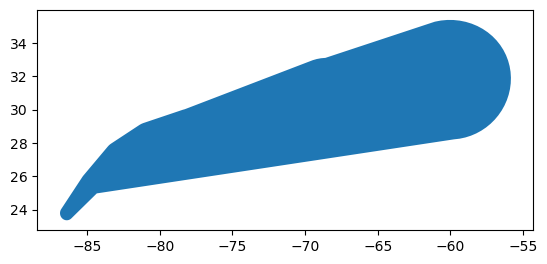

In [129]:
adeck=read_adeck_dat_file_to_gdf("z:\\Event_Monitor\\forecast_data\\aal142024.dat")

ofcl_gdf = adeck[adeck['ModelName'] == 'OFCL']

ofcl_gdf['geometry'] = ofcl_gdf.apply(lambda row: Point(row['Longitude'], row['Latitude']), axis=1)
ofcl_gdf = gpd.GeoDataFrame(ofcl_gdf, geometry='geometry', crs="EPSG:4326")


selected_forecast_datetime = pd.to_datetime("2024100818", format='%Y%m%d%H')
adeck_rel=adeck[adeck['DateTime']==selected_forecast_datetime]

uncertainty_cone_gdf = create_uncertainty_cone(adeck_rel)
uncertainty_cone_gdf.plot()

#fig=create_forecast_map(adeck,selected_forecast_datetime)
#fig

In [171]:
import plotly.graph_objects as go
import geopandas as gpd

def create_forecast_map_with_cone(adeck_gdf, selected_forecast_datetime):
    """
    Reads the gdf of the forecasts file and creates a Plotly map of the forecast tracks, including the uncertainty cone.

    Parameters:
    - adeck_gdf: GeoDatFrame with a point geometry column of the target dat file (a deck)
    - selected_forecast_datetime: str, the forecast date and time in YYYYMMDDHH format.

    Returns:
    - fig: Plotly figure object.
    """
    # Filter by forecast datetime if provided
    if selected_forecast_datetime:
        adeck_gdf = adeck_gdf[adeck_gdf['DateTime'] == selected_forecast_datetime]

    # Define category colors in the desired order
    category_colors = {
        'Tropical Depression': 'green',
        'Tropical Storm': 'blue',
        'Category 1': 'yellow',
        'Category 2': 'orange',
        'Category 3': 'red',
        'Category 4': 'orange',
        'Category 5': 'magenta',
        'Unknown': 'gray'
    }

    # Define the desired order for the legend
    category_order = [
        'Tropical Depression',
        'Tropical Storm',
        'Category 1',
        'Category 2',
        'Category 3',
        'Category 4',
        'Category 5',
        'Unknown'
    ]

    # Map category to colors based on the updated category_colors
    adeck_gdf['Color'] = adeck_gdf['Category'].apply(lambda x: category_colors.get(x, 'gray'))

    # Sort the DataFrame by ModelName and ValidTime to ensure lines connect correctly per model
    adeck_gdf = adeck_gdf.sort_values(['ModelName', 'ValidTime'])

    # Initialize the Plotly figure
    fig = go.Figure()

    # Add a line trace for each model (white lines connecting points of the same model)
    models = adeck_gdf['ModelName'].unique()
    for model in models:
        model_gdf = adeck_gdf[adeck_gdf['ModelName'] == model].sort_values('ValidTime')
        if model_gdf.empty:
            continue
        fig.add_trace(go.Scattermapbox(
            lat=model_gdf['Latitude'],
            lon=model_gdf['Longitude'],
            mode='lines',
            line=dict(color='white', width=2),
            hoverinfo='none',  # No hover info for the lines
            showlegend=False    # Do not show lines in the legend
        ))

    # Group data by Category in the specified order and plot the markers
    for category in category_order:
        category_gdf = adeck_gdf[adeck_gdf['Category'] == category]
        if not category_gdf.empty:
            fig.add_trace(go.Scattermapbox(
                lat=category_gdf['Latitude'],
                lon=category_gdf['Longitude'],
                mode='markers',
                name=category,
                marker=dict(
                    size=8,
                    color=category_colors[category],  # Single color per category
                ),
                text=category_gdf.apply(lambda row: f"Time: {row['ValidTime']:%Y-%m-%d %H:%M UTC}<br>"
                                               f"Wind Speed (mph): {row['MaxWindSpeed_mph']:.1f}<br>"
                                               f"Central Pressure (mb): {row['MinPressure']}<br>"
                                               f"Category: {row['Category']}<br>"
                                               f"Model: {row['ModelName']}", axis=1),
                hoverinfo='text'
            ))

    # Generate the uncertainty cone
    cone_gdf = create_uncertainty_cone(adeck_gdf)

    # If the cone exists, add it to the map
    if not cone_gdf.empty:
        # Extract lat/lon coordinates for plotting
        cone_coords = cone_gdf.geometry[0].exterior.coords.xy
        cone_lats, cone_lons = list(cone_coords[1]), list(cone_coords[0])  # Convert to lists

        # Add uncertainty cone polygon to the map
        fig.add_trace(go.Scattermapbox(
            lat=cone_lats,
            lon=cone_lons,
            mode='lines',
            fill='toself',
            fillcolor='rgba(128, 128, 128, 0.7)',  # Slightly darker grey with transparency
            line=dict(color='lightgrey', width=3),  # Light grey outline
            name='Uncertainty Cone',
            hoverinfo='skip',  # No hover info for the cone
            visible='legendonly'  # Let the user toggle this layer in the legend
        ))

 # Add a logo (SVG) to the map layout
    #logo_path=os.path.join("z:\\Event_Monitor\logos\LOCKTON_logo-white-footer.svg")
    logo_path = os.path.abspath("z:\\Event_Monitor\\logos\\LOCKTON_logo-white-footer.svg")
    logo_path_url = 'file://' + logo_path.replace('\\', '/')
    print(logo_path)
    fig.update_layout(
        images=[
            dict(
                source='./logos/LOCKTON_logo-white-footer.svg',  # Path to the SVG image
                #source=logo_path_url,
                xref="paper", yref="paper",  # Relative to the plot area
                x=0.01, y=0.99,  # Position of the logo
                sizex=0.15, sizey=0.15,  # Size of the logo
                xanchor="left", yanchor="top"  # Anchor the image position
            )
        ],
        # Set up the map layout with a dark style
        mapbox_style='carto-darkmatter',  # Use a dark basemap
        mapbox_zoom=4,
        mapbox_center={"lat": adeck_gdf['Latitude'].mean(), "lon": adeck_gdf['Longitude'].mean()},
        margin={"r": 0, "t": 0, "l": 0, "b": 0},
        legend_title_text='Storm Category',
        legend=dict(
            itemsizing='constant'
        )
    )

    return fig

In [172]:
adeck=read_adeck_dat_file_to_gdf("z:\\Event_Monitor\\forecast_data\\aal142024.dat")

selected_forecast_datetime = pd.to_datetime("2024100718", format='%Y%m%d%H')

fig=create_forecast_map_with_cone(adeck,selected_forecast_datetime)
fig

Removed 818 rows with Latitude or Longitude equal to 0.


C:\Users\alvaro.farias\AppData\Local\Temp\3\ipykernel_7524\454599412.py:44: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



No radius found for Basin: AL, Forecast Hour: 0
No radius found for Basin: AL, Forecast Hour: 3
No radius found for Basin: AL, Forecast Hour: 3
No radius found for Basin: AL, Forecast Hour: 3
No radius found for Basin: AL, Forecast Hour: 0
No radius found for Basin: AL, Forecast Hour: 0
z:\Event_Monitor\logos\LOCKTON_logo-white-footer.svg


In [138]:
adeck=gpd.read_parquet("./forecast_Data_parquet/aal142024.parquet")

In [140]:
adeck["DateTime"]

0       2024-10-05 00:00:00+00:00
1       2024-10-05 00:00:00+00:00
2       2024-10-05 00:00:00+00:00
3       2024-10-05 00:00:00+00:00
4       2024-10-05 00:00:00+00:00
                   ...           
95856   2024-10-11 00:00:00+00:00
95857   2024-10-11 00:00:00+00:00
95858   2024-10-11 00:00:00+00:00
95859   2024-10-11 00:00:00+00:00
95860   2024-10-11 00:00:00+00:00
Name: DateTime, Length: 95043, dtype: datetime64[ns, UTC]